In [1]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pkl_path = "data/samsemo_en_article.pkl"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

In [3]:
# Data Structure Exploration

# Basic structure preview
print(type(data))         # Dict, list, or DataFrame likely
print(len(data))          # Number of entries
print(data.keys())        # Keys in data

# If data is a dict with splits (train/valid/test):
for split in data.keys():
    if split in data:
        print(f"\n=== {split.upper()} SPLIT ===")
        # Check the first example
        first_example = data[split]
        print("Keys in first example:", first_example.keys())
        print(f"Type of data['{split}']: {type(data[split])}")
        # Possibly print entire example if it's small
        # print("First example data:", first_example)

<class 'dict'>
3
dict_keys(['train', 'valid', 'test'])

=== TRAIN SPLIT ===
Keys in first example: dict_keys(['text', 'audio', 'spec_lens', 'vision', 'imgs_lens', 'labels'])
Type of data['train']: <class 'dict'>

=== VALID SPLIT ===
Keys in first example: dict_keys(['text', 'audio', 'spec_lens', 'vision', 'imgs_lens', 'labels'])
Type of data['valid']: <class 'dict'>

=== TEST SPLIT ===
Keys in first example: dict_keys(['text', 'audio', 'spec_lens', 'vision', 'imgs_lens', 'labels'])
Type of data['test']: <class 'dict'>


In [4]:
# Add this after loading the data
# Check the structure and type of text data
print("\n=== TEXT DATA ANALYSIS ===")
print(f"Type of text data: {type(data['train']['text'])}")
print(f"Length of text data: {len(data['train']['text'])}")
print(f"First text example type: {type(data['train']['text'][0])}")
if isinstance(data['train']['text'][0], (str, list)):
    print(f"First text example: {data['train']['text'][0][:100]}")  # First 100 chars if text
else:
    print(f"First text example shape: {data['train']['text'][0].shape}")  # Shape if tensor

# Check for NaN/Inf values in inputs
text_sample = data['train']['text'][0]
if torch.is_tensor(text_sample):
    print(f"Contains NaN: {torch.isnan(text_sample).any()}")
    print(f"Contains Inf: {torch.isinf(text_sample).any()}")
    
print('--'*30)

# Label distribution analysis
print("=== LABEL DISTRIBUTION ===")
labels = np.array(data['train']['labels'])
label_sums = labels.sum(axis=0)  # pos count
neg_count = len(labels) - label_sums # neg count
pos_ratios = label_sums / len(labels) 
for i, ratio in enumerate(pos_ratios):
    print(f"Class {i}: {ratio:.4f} ({int(label_sums[i])} positives out of {len(labels)})")

#print('--'*30)
# Check the label dimensions

print("First label type:", type(data["train"]["labels"][0]))
print("First label example:", data["train"]["labels"][0])
print("Number of emotion categories:", len(data["train"]["labels"][0]))

# Look at a few examples
for i in range(3):
    print(f"Example {i}: {data['train']['labels'][i]}")


=== TEXT DATA ANALYSIS ===
Type of text data: <class 'torch.Tensor'>
Length of text data: 2728
First text example type: <class 'torch.Tensor'>
First text example shape: torch.Size([50, 768])
Contains NaN: False
Contains Inf: False
------------------------------------------------------------
=== LABEL DISTRIBUTION ===
Class 0: 0.1085 (296 positives out of 2728)
Class 1: 0.3548 (968 positives out of 2728)
Class 2: 0.0740 (202 positives out of 2728)
Class 3: 0.0601 (164 positives out of 2728)
Class 4: 0.4274 (1166 positives out of 2728)
First label type: <class 'list'>
First label example: [0, 0, 0, 1, 0]
Number of emotion categories: 5
Example 0: [0, 0, 0, 1, 0]
Example 1: [0, 1, 0, 0, 0]
Example 2: [0, 0, 0, 1, 0]


In [5]:
class SAMSEMODataset(Dataset):
    def __init__(self, data_dict, split='train', use_bert_tokenizer=False):
        """
        Args:
            data_dict: The loaded SAMSEMO pickle data
            split: 'train', 'valid', or 'test'
            use_bert_tokenizer: Whether to process text with BERT tokenizer or use pre-computed embeddings
        """
        self.data = data_dict[split]
        self.text_data = self.data['text']
        self.labels = self.data['labels']
        self.use_bert_tokenizer = use_bert_tokenizer
        
        if use_bert_tokenizer:
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Check label format and get dimension
        if isinstance(self.labels[0], list):
            self.num_labels = len(self.labels[0])
            print(f"Dataset has {self.num_labels} emotion categories")
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.use_bert_tokenizer:
            # If text data is raw text, tokenize it
            encoding = self.tokenizer(
                self.text_data[idx],
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            text = {k: v.squeeze(0) for k, v in encoding.items()}
        else:
            # If text data is already BERT embeddings
            text = self.text_data[idx]  # Assuming these are tensors
            
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return {'text': text, 'labels': label}

# Create proper collate function for variable length sequences
def collate_fn(batch):
    labels = torch.stack([item['labels'] for item in batch])
    
    # Check if text is dictionary (BERT tokenizer output) or tensor (embeddings)
    if isinstance(batch[0]['text'], dict):
        # BERT tokenizer output
        text = {
            key: torch.stack([item['text'][key] for item in batch]) 
            for key in batch[0]['text'].keys()
        }
    else:
        # Pre-computed embeddings - handle variable length sequences
        texts = [item['text'] for item in batch]
        max_len = max(t.shape[0] for t in texts)
        text = torch.stack([
            F.pad(t, (0, 0, 0, max_len - t.shape[0])) for t in texts
        ])
        
    return {'text': text, 'labels': labels}

In [6]:
class BERTEmotionClassifier(nn.Module):
    def __init__(self, num_labels=5, use_pretrained=True):
        super().__init__()
        if use_pretrained:
            # Use the full BERT model for fine-tuning
            self.bert = BertModel.from_pretrained('bert-base-uncased')
        else:
            # If data already contains BERT embeddings
            self.bert = None
            
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),  # BERT hidden size is 768
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_labels)
        )
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, embeddings=None):
        if self.bert is not None and input_ids is not None:
            # Process raw text with BERT
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids if token_type_ids is not None else None
            )
            pooled_output = outputs.pooler_output  # [CLS] token representation
        else:
            # Use provided embeddings
            if embeddings.dim() == 3:  # [batch, seq_len, hidden]
                # Apply mean pooling over sequence dimension
                pooled_output = embeddings.mean(dim=1)
            else:
                pooled_output = embeddings
                
        x = self.dropout(pooled_output)
        logits = self.classifier(x)
        return logits

In [7]:
def find_optimal_threshold(outputs, targets, thresholds=None):
    """
    Find optimal threshold for each class that maximizes F1 score
    
    Args:
        outputs: Model sigmoid outputs (probabilities) as numpy array
        targets: Ground truth labels as numpy array
        thresholds: Range of thresholds to try (default: 0.1 to 0.9)
        
    Returns:
        List of optimal thresholds for each class
    """
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.05)
    
    best_thresholds = []
    for i in range(targets.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        
        for threshold in thresholds:
            preds = (outputs[:, i] > threshold).astype(float)
            f1 = f1_score(targets[:, i], preds, average='binary')
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = threshold
                
        best_thresholds.append(best_thresh)
        print(f"Class {i}: Best threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")
    
    return best_thresholds

In [8]:
# Create datasets with proper splits
train_dataset = SAMSEMODataset(data, 'train', use_bert_tokenizer=False)  # Set True if raw text
val_dataset = SAMSEMODataset(data, 'valid', use_bert_tokenizer=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTEmotionClassifier(num_labels=train_dataset.num_labels, use_pretrained=False).to(device)  # Set True if raw text

# Training parameters
# criterion = nn.BCEWithLogitsLoss()  # Multi-label classification
pos_weight = torch.tensor(neg_count/label_sums, dtype=torch.float).to(device)
print("Class weights:", pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Weighted loss for imbalanced classes
optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 120

# Training history tracker
history = {
    'train_loss': [],
    'val_loss': [],
    'f1_scores': [],
    'accuracy': []
}

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Handle different input types
        if isinstance(batch['text'], dict):
            # BERT tokenizer output
            inputs = {k: v.to(device) for k, v in batch['text'].items()}
            outputs = model(**inputs)
        else:
            # Pre-computed embeddings
            text = batch['text'].to(device)
            outputs = model(embeddings=text)
            
        labels = batch['labels'].to(device)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    all_outputs = []  # Store raw outputs before applying threshold
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            if isinstance(batch['text'], dict):
                inputs = {k: v.to(device) for k, v in batch['text'].items()}
                outputs = model(**inputs)
            else:
                text = batch['text'].to(device)
                outputs = model(embeddings=text)
                
            labels = batch['labels'].to(device)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Using direct threshold:
            # preds = (torch.sigmoid(outputs) > 0.2).float() # Threshold
            # all_preds.append(preds.cpu())
            
            # Store raw logits and labels for threshold optimization
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    # Convert to numpy arrays
    all_outputs = torch.cat(all_outputs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    #######################################################################
    
    sigmoid_outputs = 1/(1 + np.exp(-all_outputs))  # Apply sigmoid
    
    # Find optimal thresholds
    print("\nFinding optimal thresholds:")
    best_thresholds = find_optimal_threshold(sigmoid_outputs, all_labels)
    
    # Apply the optimal thresholds
    all_preds = np.zeros_like(all_outputs)
    for i, threshold in enumerate(best_thresholds):
        all_preds[:, i] = (sigmoid_outputs[:, i] > threshold).astype(float)
    
    #######################################################################

    # Calculate metrics 
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = (all_preds == all_labels).mean()
    
    train_loss_avg = train_loss/len(train_loader)
    val_loss_avg = val_loss/len(val_loader)
    
    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Train Loss: {train_loss_avg:.4f}")
    print(f"Val Loss: {val_loss_avg:.4f}")  
    print(f"F1 Score: {f1:.4f}")
    print("-" * 70)

    history['train_loss'].append(train_loss_avg)
    history['val_loss'].append(val_loss_avg)
    history['f1_scores'].append(f1)
    history['accuracy'].append(accuracy)

Dataset has 5 emotion categories
Dataset has 5 emotion categories
Class weights: tensor([ 8.2162,  1.8182, 12.5050, 15.6341,  1.3396], device='cuda:0')


Validation: 100%|██████████| 37/37 [00:00<00:00, 656.29it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2232
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.10, F1 = 0.1340
Class 3: Best threshold = 0.10, F1 = 0.1068
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 1/120
Accuracy: 0.2072
Train Loss: 1.1018
Val Loss: 1.0977
F1 Score: 0.3149
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 648.39it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2278
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.50, F1 = 0.1393
Class 3: Best threshold = 0.10, F1 = 0.1068
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 2/120
Accuracy: 0.2790
Train Loss: 1.0996
Val Loss: 1.0965
F1 Score: 0.3169
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 602.95it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2245
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.50, F1 = 0.1451
Class 3: Best threshold = 0.10, F1 = 0.1068
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 3/120
Accuracy: 0.2954
Train Loss: 1.0981
Val Loss: 1.0954
F1 Score: 0.3174
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 642.66it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2289
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.50, F1 = 0.1484
Class 3: Best threshold = 0.50, F1 = 0.1102
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 4/120
Accuracy: 0.4766
Train Loss: 1.0974
Val Loss: 1.0939
F1 Score: 0.3196
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 669.05it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2409
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.50, F1 = 0.1465
Class 3: Best threshold = 0.50, F1 = 0.1437
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 5/120
Accuracy: 0.4940
Train Loss: 1.0939
Val Loss: 1.0924
F1 Score: 0.3283
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 641.24it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2585
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.50, F1 = 0.1620
Class 3: Best threshold = 0.50, F1 = 0.1442
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 6/120
Accuracy: 0.5091
Train Loss: 1.0927
Val Loss: 1.0908
F1 Score: 0.3350
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 679.73it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.2939
Class 1: Best threshold = 0.10, F1 = 0.4805
Class 2: Best threshold = 0.50, F1 = 0.1720
Class 3: Best threshold = 0.50, F1 = 0.1333
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 7/120
Accuracy: 0.5169
Train Loss: 1.0900
Val Loss: 1.0891
F1 Score: 0.3420
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 562.38it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3148
Class 1: Best threshold = 0.45, F1 = 0.4824
Class 2: Best threshold = 0.50, F1 = 0.1631
Class 3: Best threshold = 0.50, F1 = 0.1441
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 8/120
Accuracy: 0.5446
Train Loss: 1.0877
Val Loss: 1.0875
F1 Score: 0.3469
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 686.99it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3366
Class 1: Best threshold = 0.45, F1 = 0.4856
Class 2: Best threshold = 0.50, F1 = 0.1577
Class 3: Best threshold = 0.50, F1 = 0.1343
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 9/120
Accuracy: 0.5361
Train Loss: 1.0865
Val Loss: 1.0859
F1 Score: 0.3488
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 684.33it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3392
Class 1: Best threshold = 0.45, F1 = 0.5007
Class 2: Best threshold = 0.50, F1 = 0.1552
Class 3: Best threshold = 0.50, F1 = 0.1228
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 10/120
Accuracy: 0.5665
Train Loss: 1.0829
Val Loss: 1.0843
F1 Score: 0.3496
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 626.72it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3356
Class 1: Best threshold = 0.45, F1 = 0.5027
Class 2: Best threshold = 0.50, F1 = 0.1532
Class 3: Best threshold = 0.50, F1 = 0.1391
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 11/120
Accuracy: 0.5648
Train Loss: 1.0839
Val Loss: 1.0825
F1 Score: 0.3521
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 684.18it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3478
Class 1: Best threshold = 0.45, F1 = 0.5027
Class 2: Best threshold = 0.50, F1 = 0.1577
Class 3: Best threshold = 0.50, F1 = 0.1328
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 12/120
Accuracy: 0.5651
Train Loss: 1.0815
Val Loss: 1.0811
F1 Score: 0.3542
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 660.59it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3482
Class 1: Best threshold = 0.45, F1 = 0.5027
Class 2: Best threshold = 0.50, F1 = 0.1610
Class 3: Best threshold = 0.50, F1 = 0.1328
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 13/120
Accuracy: 0.5638
Train Loss: 1.0774
Val Loss: 1.0794
F1 Score: 0.3549
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 656.24it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3424
Class 1: Best threshold = 0.45, F1 = 0.5027
Class 2: Best threshold = 0.50, F1 = 0.1694
Class 3: Best threshold = 0.50, F1 = 0.1364
Class 4: Best threshold = 0.45, F1 = 0.6307
Epoch 14/120
Accuracy: 0.5610
Train Loss: 1.0753
Val Loss: 1.0777
F1 Score: 0.3563
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.85it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3399
Class 1: Best threshold = 0.45, F1 = 0.5027
Class 2: Best threshold = 0.50, F1 = 0.1617
Class 3: Best threshold = 0.50, F1 = 0.1377
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 15/120
Accuracy: 0.5610
Train Loss: 1.0738
Val Loss: 1.0760
F1 Score: 0.3544
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 649.62it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3554
Class 1: Best threshold = 0.50, F1 = 0.5102
Class 2: Best threshold = 0.50, F1 = 0.1681
Class 3: Best threshold = 0.50, F1 = 0.1285
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 16/120
Accuracy: 0.6181
Train Loss: 1.0714
Val Loss: 1.0744
F1 Score: 0.3584
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 626.29it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3565
Class 1: Best threshold = 0.50, F1 = 0.5265
Class 2: Best threshold = 0.50, F1 = 0.1667
Class 3: Best threshold = 0.50, F1 = 0.1319
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 17/120
Accuracy: 0.6198
Train Loss: 1.0689
Val Loss: 1.0730
F1 Score: 0.3623
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 672.52it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3556
Class 1: Best threshold = 0.50, F1 = 0.5072
Class 2: Best threshold = 0.50, F1 = 0.1706
Class 3: Best threshold = 0.50, F1 = 0.1353
Class 4: Best threshold = 0.45, F1 = 0.6313
Epoch 18/120
Accuracy: 0.6232
Train Loss: 1.0671
Val Loss: 1.0713
F1 Score: 0.3600
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 679.52it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3670
Class 1: Best threshold = 0.50, F1 = 0.5137
Class 2: Best threshold = 0.50, F1 = 0.1698
Class 3: Best threshold = 0.50, F1 = 0.1328
Class 4: Best threshold = 0.45, F1 = 0.6313
Epoch 19/120
Accuracy: 0.6205
Train Loss: 1.0638
Val Loss: 1.0699
F1 Score: 0.3629
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 646.20it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3509
Class 1: Best threshold = 0.50, F1 = 0.5161
Class 2: Best threshold = 0.50, F1 = 0.1690
Class 3: Best threshold = 0.50, F1 = 0.1441
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 20/120
Accuracy: 0.6297
Train Loss: 1.0626
Val Loss: 1.0683
F1 Score: 0.3620
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 687.49it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3524
Class 1: Best threshold = 0.50, F1 = 0.5198
Class 2: Best threshold = 0.50, F1 = 0.1722
Class 3: Best threshold = 0.50, F1 = 0.1452
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 21/120
Accuracy: 0.6274
Train Loss: 1.0599
Val Loss: 1.0668
F1 Score: 0.3639
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 623.79it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3721
Class 1: Best threshold = 0.50, F1 = 0.5269
Class 2: Best threshold = 0.55, F1 = 0.1967
Class 3: Best threshold = 0.50, F1 = 0.1435
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 22/120
Accuracy: 0.6838
Train Loss: 1.0591
Val Loss: 1.0655
F1 Score: 0.3739
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 631.79it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3654
Class 1: Best threshold = 0.50, F1 = 0.5243
Class 2: Best threshold = 0.50, F1 = 0.1792
Class 3: Best threshold = 0.50, F1 = 0.1519
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 23/120
Accuracy: 0.6349
Train Loss: 1.0536
Val Loss: 1.0641
F1 Score: 0.3702
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 684.67it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3585
Class 1: Best threshold = 0.50, F1 = 0.5282
Class 2: Best threshold = 0.55, F1 = 0.1846
Class 3: Best threshold = 0.50, F1 = 0.1435
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 24/120
Accuracy: 0.6790
Train Loss: 1.0534
Val Loss: 1.0627
F1 Score: 0.3689
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.92it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3551
Class 1: Best threshold = 0.50, F1 = 0.5320
Class 2: Best threshold = 0.55, F1 = 0.1765
Class 3: Best threshold = 0.55, F1 = 0.1509
Class 4: Best threshold = 0.45, F1 = 0.6302
Epoch 25/120
Accuracy: 0.7296
Train Loss: 1.0534
Val Loss: 1.0613
F1 Score: 0.3690
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 648.65it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3858
Class 1: Best threshold = 0.50, F1 = 0.5267
Class 2: Best threshold = 0.50, F1 = 0.1739
Class 3: Best threshold = 0.50, F1 = 0.1532
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 26/120
Accuracy: 0.6462
Train Loss: 1.0476
Val Loss: 1.0601
F1 Score: 0.3739
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 645.68it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3721
Class 1: Best threshold = 0.50, F1 = 0.5288
Class 2: Best threshold = 0.55, F1 = 0.1918
Class 3: Best threshold = 0.50, F1 = 0.1497
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 27/120
Accuracy: 0.7087
Train Loss: 1.0467
Val Loss: 1.0585
F1 Score: 0.3745
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 628.79it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3692
Class 1: Best threshold = 0.50, F1 = 0.5299
Class 2: Best threshold = 0.55, F1 = 0.1892
Class 3: Best threshold = 0.50, F1 = 0.1466
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 28/120
Accuracy: 0.7070
Train Loss: 1.0479
Val Loss: 1.0572
F1 Score: 0.3730
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 635.14it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3910
Class 1: Best threshold = 0.50, F1 = 0.5223
Class 2: Best threshold = 0.55, F1 = 0.1842
Class 3: Best threshold = 0.55, F1 = 0.1754
Class 4: Best threshold = 0.45, F1 = 0.6315
Epoch 29/120
Accuracy: 0.7494
Train Loss: 1.0439
Val Loss: 1.0559
F1 Score: 0.3809
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 654.04it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3817
Class 1: Best threshold = 0.50, F1 = 0.5240
Class 2: Best threshold = 0.55, F1 = 0.1892
Class 3: Best threshold = 0.55, F1 = 0.1613
Class 4: Best threshold = 0.45, F1 = 0.6360
Epoch 30/120
Accuracy: 0.7497
Train Loss: 1.0424
Val Loss: 1.0551
F1 Score: 0.3784
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 671.50it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3939
Class 1: Best threshold = 0.50, F1 = 0.5278
Class 2: Best threshold = 0.50, F1 = 0.1801
Class 3: Best threshold = 0.55, F1 = 0.1695
Class 4: Best threshold = 0.45, F1 = 0.6368
Epoch 31/120
Accuracy: 0.7128
Train Loss: 1.0377
Val Loss: 1.0539
F1 Score: 0.3816
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 650.45it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3881
Class 1: Best threshold = 0.50, F1 = 0.5280
Class 2: Best threshold = 0.55, F1 = 0.1750
Class 3: Best threshold = 0.55, F1 = 0.1667
Class 4: Best threshold = 0.45, F1 = 0.6368
Epoch 32/120
Accuracy: 0.7491
Train Loss: 1.0385
Val Loss: 1.0526
F1 Score: 0.3789
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.89it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3881
Class 1: Best threshold = 0.50, F1 = 0.5288
Class 2: Best threshold = 0.50, F1 = 0.1860
Class 3: Best threshold = 0.55, F1 = 0.1613
Class 4: Best threshold = 0.45, F1 = 0.6399
Epoch 33/120
Accuracy: 0.7121
Train Loss: 1.0355
Val Loss: 1.0516
F1 Score: 0.3808
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 631.66it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3881
Class 1: Best threshold = 0.50, F1 = 0.5257
Class 2: Best threshold = 0.50, F1 = 0.1801
Class 3: Best threshold = 0.55, F1 = 0.1562
Class 4: Best threshold = 0.45, F1 = 0.6381
Epoch 34/120
Accuracy: 0.7142
Train Loss: 1.0341
Val Loss: 1.0502
F1 Score: 0.3776
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 641.46it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3881
Class 1: Best threshold = 0.50, F1 = 0.5263
Class 2: Best threshold = 0.50, F1 = 0.1826
Class 3: Best threshold = 0.55, F1 = 0.1562
Class 4: Best threshold = 0.45, F1 = 0.6373
Epoch 35/120
Accuracy: 0.7111
Train Loss: 1.0319
Val Loss: 1.0492
F1 Score: 0.3781
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 661.99it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3881
Class 1: Best threshold = 0.50, F1 = 0.5246
Class 2: Best threshold = 0.50, F1 = 0.1722
Class 3: Best threshold = 0.55, F1 = 0.1562
Class 4: Best threshold = 0.45, F1 = 0.6389
Epoch 36/120
Accuracy: 0.7142
Train Loss: 1.0295
Val Loss: 1.0482
F1 Score: 0.3760
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 626.73it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3852
Class 1: Best threshold = 0.50, F1 = 0.5255
Class 2: Best threshold = 0.55, F1 = 0.1728
Class 3: Best threshold = 0.55, F1 = 0.1587
Class 4: Best threshold = 0.45, F1 = 0.6389
Epoch 37/120
Accuracy: 0.7501
Train Loss: 1.0297
Val Loss: 1.0473
F1 Score: 0.3762
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 681.17it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3942
Class 1: Best threshold = 0.50, F1 = 0.5255
Class 2: Best threshold = 0.50, F1 = 0.1683
Class 3: Best threshold = 0.55, F1 = 0.1639
Class 4: Best threshold = 0.45, F1 = 0.6364
Epoch 38/120
Accuracy: 0.7159
Train Loss: 1.0291
Val Loss: 1.0461
F1 Score: 0.3776
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 682.99it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3824
Class 1: Best threshold = 0.50, F1 = 0.5280
Class 2: Best threshold = 0.50, F1 = 0.1675
Class 3: Best threshold = 0.55, F1 = 0.1846
Class 4: Best threshold = 0.45, F1 = 0.6344
Epoch 39/120
Accuracy: 0.7138
Train Loss: 1.0260
Val Loss: 1.0455
F1 Score: 0.3794
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 659.90it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3942
Class 1: Best threshold = 0.50, F1 = 0.5184
Class 2: Best threshold = 0.50, F1 = 0.1739
Class 3: Best threshold = 0.55, F1 = 0.1846
Class 4: Best threshold = 0.45, F1 = 0.6363
Epoch 40/120
Accuracy: 0.7135
Train Loss: 1.0265
Val Loss: 1.0442
F1 Score: 0.3815
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 684.61it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3913
Class 1: Best threshold = 0.50, F1 = 0.5212
Class 2: Best threshold = 0.50, F1 = 0.1649
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.45, F1 = 0.6326
Epoch 41/120
Accuracy: 0.7152
Train Loss: 1.0199
Val Loss: 1.0434
F1 Score: 0.3778
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 689.56it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4029
Class 1: Best threshold = 0.50, F1 = 0.5212
Class 2: Best threshold = 0.50, F1 = 0.1709
Class 3: Best threshold = 0.55, F1 = 0.1846
Class 4: Best threshold = 0.45, F1 = 0.6349
Epoch 42/120
Accuracy: 0.7166
Train Loss: 1.0184
Val Loss: 1.0425
F1 Score: 0.3829
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 649.18it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3938
Class 1: Best threshold = 0.50, F1 = 0.5212
Class 2: Best threshold = 0.60, F1 = 0.2034
Class 3: Best threshold = 0.55, F1 = 0.1818
Class 4: Best threshold = 0.45, F1 = 0.6349
Epoch 43/120
Accuracy: 0.7450
Train Loss: 1.0167
Val Loss: 1.0418
F1 Score: 0.3870
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 632.51it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.3938
Class 1: Best threshold = 0.50, F1 = 0.5202
Class 2: Best threshold = 0.60, F1 = 0.1905
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.45, F1 = 0.6358
Epoch 44/120
Accuracy: 0.7429
Train Loss: 1.0169
Val Loss: 1.0408
F1 Score: 0.3839
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 643.69it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4000
Class 1: Best threshold = 0.50, F1 = 0.5221
Class 2: Best threshold = 0.60, F1 = 0.1935
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.45, F1 = 0.6305
Epoch 45/120
Accuracy: 0.7538
Train Loss: 1.0167
Val Loss: 1.0399
F1 Score: 0.3851
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 683.90it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4000
Class 1: Best threshold = 0.50, F1 = 0.5231
Class 2: Best threshold = 0.60, F1 = 0.1935
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.45, F1 = 0.6322
Epoch 46/120
Accuracy: 0.7545
Train Loss: 1.0154
Val Loss: 1.0390
F1 Score: 0.3856
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 653.52it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4085
Class 1: Best threshold = 0.50, F1 = 0.5255
Class 2: Best threshold = 0.60, F1 = 0.1905
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.45, F1 = 0.6314
Epoch 47/120
Accuracy: 0.7552
Train Loss: 1.0157
Val Loss: 1.0380
F1 Score: 0.3870
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 663.48it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.60, F1 = 0.4031
Class 1: Best threshold = 0.50, F1 = 0.5261
Class 2: Best threshold = 0.60, F1 = 0.1846
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 48/120
Accuracy: 0.7480
Train Loss: 1.0151
Val Loss: 1.0371
F1 Score: 0.3846
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 673.84it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.60, F1 = 0.3969
Class 1: Best threshold = 0.50, F1 = 0.5265
Class 2: Best threshold = 0.60, F1 = 0.1791
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 49/120
Accuracy: 0.7480
Train Loss: 1.0114
Val Loss: 1.0360
F1 Score: 0.3823
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 662.15it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.3973
Class 1: Best threshold = 0.45, F1 = 0.5255
Class 2: Best threshold = 0.60, F1 = 0.1846
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 50/120
Accuracy: 0.7200
Train Loss: 1.0107
Val Loss: 1.0356
F1 Score: 0.3833
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 674.49it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.60, F1 = 0.3939
Class 1: Best threshold = 0.45, F1 = 0.5273
Class 2: Best threshold = 0.50, F1 = 0.1837
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 51/120
Accuracy: 0.6875
Train Loss: 1.0082
Val Loss: 1.0346
F1 Score: 0.3828
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 669.46it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.50, F1 = 0.4000
Class 1: Best threshold = 0.50, F1 = 0.5295
Class 2: Best threshold = 0.60, F1 = 0.1846
Class 3: Best threshold = 0.50, F1 = 0.1831
Class 4: Best threshold = 0.10, F1 = 0.6300
Epoch 52/120
Accuracy: 0.7152
Train Loss: 1.0067
Val Loss: 1.0343
F1 Score: 0.3854
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 625.78it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4054
Class 1: Best threshold = 0.50, F1 = 0.5301
Class 2: Best threshold = 0.60, F1 = 0.1818
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.40, F1 = 0.6303
Epoch 53/120
Accuracy: 0.7460
Train Loss: 1.0054
Val Loss: 1.0336
F1 Score: 0.3854
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 677.89it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4027
Class 1: Best threshold = 0.50, F1 = 0.5282
Class 2: Best threshold = 0.50, F1 = 0.1846
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.40, F1 = 0.6326
Epoch 54/120
Accuracy: 0.7108
Train Loss: 1.0039
Val Loss: 1.0328
F1 Score: 0.3854
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 655.93it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4027
Class 1: Best threshold = 0.50, F1 = 0.5288
Class 2: Best threshold = 0.50, F1 = 0.1799
Class 3: Best threshold = 0.55, F1 = 0.1765
Class 4: Best threshold = 0.40, F1 = 0.6333
Epoch 55/120
Accuracy: 0.7111
Train Loss: 1.0018
Val Loss: 1.0323
F1 Score: 0.3842
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 665.69it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4027
Class 1: Best threshold = 0.45, F1 = 0.5314
Class 2: Best threshold = 0.50, F1 = 0.1895
Class 3: Best threshold = 0.55, F1 = 0.1765
Class 4: Best threshold = 0.40, F1 = 0.6333
Epoch 56/120
Accuracy: 0.6906
Train Loss: 1.0005
Val Loss: 1.0314
F1 Score: 0.3867
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 654.08it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4082
Class 1: Best threshold = 0.45, F1 = 0.5333
Class 2: Best threshold = 0.50, F1 = 0.1837
Class 3: Best threshold = 0.55, F1 = 0.1791
Class 4: Best threshold = 0.40, F1 = 0.6318
Epoch 57/120
Accuracy: 0.6903
Train Loss: 1.0028
Val Loss: 1.0306
F1 Score: 0.3872
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 684.62it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4082
Class 1: Best threshold = 0.45, F1 = 0.5325
Class 2: Best threshold = 0.50, F1 = 0.1837
Class 3: Best threshold = 0.55, F1 = 0.1739
Class 4: Best threshold = 0.40, F1 = 0.6341
Epoch 58/120
Accuracy: 0.6903
Train Loss: 0.9994
Val Loss: 1.0299
F1 Score: 0.3865
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 665.74it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4189
Class 1: Best threshold = 0.45, F1 = 0.5361
Class 2: Best threshold = 0.55, F1 = 0.2124
Class 3: Best threshold = 0.55, F1 = 0.1765
Class 4: Best threshold = 0.40, F1 = 0.6348
Epoch 59/120
Accuracy: 0.7176
Train Loss: 0.9972
Val Loss: 1.0292
F1 Score: 0.3957
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 668.83it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4314
Class 1: Best threshold = 0.50, F1 = 0.5336
Class 2: Best threshold = 0.55, F1 = 0.2087
Class 3: Best threshold = 0.55, F1 = 0.1690
Class 4: Best threshold = 0.45, F1 = 0.6348
Epoch 60/120
Accuracy: 0.7443
Train Loss: 1.0000
Val Loss: 1.0288
F1 Score: 0.3955
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 669.87it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4314
Class 1: Best threshold = 0.45, F1 = 0.5331
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.2133
Class 4: Best threshold = 0.40, F1 = 0.6323
Epoch 61/120
Accuracy: 0.7111
Train Loss: 0.9970
Val Loss: 1.0279
F1 Score: 0.4020
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 690.86it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4342
Class 1: Best threshold = 0.45, F1 = 0.5340
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.1892
Class 4: Best threshold = 0.45, F1 = 0.6356
Epoch 62/120
Accuracy: 0.7227
Train Loss: 0.9963
Val Loss: 1.0275
F1 Score: 0.3986
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 682.08it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4314
Class 1: Best threshold = 0.45, F1 = 0.5340
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.1739
Class 4: Best threshold = 0.45, F1 = 0.6382
Epoch 63/120
Accuracy: 0.7244
Train Loss: 0.9949
Val Loss: 1.0270
F1 Score: 0.3955
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 661.86it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4359
Class 1: Best threshold = 0.50, F1 = 0.5364
Class 2: Best threshold = 0.55, F1 = 0.2087
Class 3: Best threshold = 0.55, F1 = 0.1739
Class 4: Best threshold = 0.45, F1 = 0.6348
Epoch 64/120
Accuracy: 0.7491
Train Loss: 0.9918
Val Loss: 1.0261
F1 Score: 0.3979
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 674.09it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4304
Class 1: Best threshold = 0.50, F1 = 0.5375
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.50, F1 = 0.1697
Class 4: Best threshold = 0.45, F1 = 0.6365
Epoch 65/120
Accuracy: 0.7203
Train Loss: 0.9943
Val Loss: 1.0252
F1 Score: 0.3948
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 672.72it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4331
Class 1: Best threshold = 0.50, F1 = 0.5364
Class 2: Best threshold = 0.55, F1 = 0.2105
Class 3: Best threshold = 0.50, F1 = 0.1728
Class 4: Best threshold = 0.45, F1 = 0.6364
Epoch 66/120
Accuracy: 0.7238
Train Loss: 0.9862
Val Loss: 1.0251
F1 Score: 0.3978
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 689.11it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4416
Class 1: Best threshold = 0.45, F1 = 0.5408
Class 2: Best threshold = 0.55, F1 = 0.2034
Class 3: Best threshold = 0.50, F1 = 0.1697
Class 4: Best threshold = 0.45, F1 = 0.6405
Epoch 67/120
Accuracy: 0.7026
Train Loss: 0.9917
Val Loss: 1.0247
F1 Score: 0.3992
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 671.64it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4359
Class 1: Best threshold = 0.50, F1 = 0.5402
Class 2: Best threshold = 0.55, F1 = 0.2069
Class 3: Best threshold = 0.50, F1 = 0.1647
Class 4: Best threshold = 0.45, F1 = 0.6397
Epoch 68/120
Accuracy: 0.7224
Train Loss: 0.9885
Val Loss: 1.0239
F1 Score: 0.3975
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 646.38it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4387
Class 1: Best threshold = 0.45, F1 = 0.5348
Class 2: Best threshold = 0.55, F1 = 0.2087
Class 3: Best threshold = 0.50, F1 = 0.1667
Class 4: Best threshold = 0.45, F1 = 0.6388
Epoch 69/120
Accuracy: 0.7015
Train Loss: 0.9839
Val Loss: 1.0236
F1 Score: 0.3975
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 660.01it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4331
Class 1: Best threshold = 0.50, F1 = 0.5391
Class 2: Best threshold = 0.55, F1 = 0.2069
Class 3: Best threshold = 0.55, F1 = 0.1842
Class 4: Best threshold = 0.45, F1 = 0.6366
Epoch 70/120
Accuracy: 0.7494
Train Loss: 0.9862
Val Loss: 1.0228
F1 Score: 0.4000
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 660.87it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4387
Class 1: Best threshold = 0.50, F1 = 0.5385
Class 2: Best threshold = 0.55, F1 = 0.1935
Class 3: Best threshold = 0.55, F1 = 0.1975
Class 4: Best threshold = 0.45, F1 = 0.6375
Epoch 71/120
Accuracy: 0.7453
Train Loss: 0.9862
Val Loss: 1.0226
F1 Score: 0.4011
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 669.62it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4387
Class 1: Best threshold = 0.45, F1 = 0.5385
Class 2: Best threshold = 0.55, F1 = 0.2051
Class 3: Best threshold = 0.55, F1 = 0.1975
Class 4: Best threshold = 0.40, F1 = 0.6350
Epoch 72/120
Accuracy: 0.7152
Train Loss: 0.9808
Val Loss: 1.0224
F1 Score: 0.4030
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 664.59it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4304
Class 1: Best threshold = 0.45, F1 = 0.5383
Class 2: Best threshold = 0.55, F1 = 0.2105
Class 3: Best threshold = 0.55, F1 = 0.1818
Class 4: Best threshold = 0.45, F1 = 0.6355
Epoch 73/120
Accuracy: 0.7296
Train Loss: 0.9822
Val Loss: 1.0214
F1 Score: 0.3993
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 625.71it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4224
Class 1: Best threshold = 0.45, F1 = 0.5386
Class 2: Best threshold = 0.65, F1 = 0.2034
Class 3: Best threshold = 0.55, F1 = 0.1905
Class 4: Best threshold = 0.40, F1 = 0.6350
Epoch 74/120
Accuracy: 0.7303
Train Loss: 0.9809
Val Loss: 1.0203
F1 Score: 0.3980
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 686.77it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4250
Class 1: Best threshold = 0.45, F1 = 0.5359
Class 2: Best threshold = 0.65, F1 = 0.2034
Class 3: Best threshold = 0.55, F1 = 0.2051
Class 4: Best threshold = 0.45, F1 = 0.6347
Epoch 75/120
Accuracy: 0.7456
Train Loss: 0.9790
Val Loss: 1.0199
F1 Score: 0.4008
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 668.08it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4198
Class 1: Best threshold = 0.50, F1 = 0.5383
Class 2: Best threshold = 0.65, F1 = 0.2034
Class 3: Best threshold = 0.55, F1 = 0.1818
Class 4: Best threshold = 0.45, F1 = 0.6348
Epoch 76/120
Accuracy: 0.7651
Train Loss: 0.9809
Val Loss: 1.0195
F1 Score: 0.3956
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 676.39it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4304
Class 1: Best threshold = 0.45, F1 = 0.5386
Class 2: Best threshold = 0.65, F1 = 0.2000
Class 3: Best threshold = 0.50, F1 = 0.1772
Class 4: Best threshold = 0.45, F1 = 0.6362
Epoch 77/120
Accuracy: 0.7224
Train Loss: 0.9807
Val Loss: 1.0192
F1 Score: 0.3965
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 664.29it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4198
Class 1: Best threshold = 0.45, F1 = 0.5415
Class 2: Best threshold = 0.55, F1 = 0.2031
Class 3: Best threshold = 0.50, F1 = 0.1830
Class 4: Best threshold = 0.45, F1 = 0.6348
Epoch 78/120
Accuracy: 0.7070
Train Loss: 0.9734
Val Loss: 1.0180
F1 Score: 0.3964
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 623.48it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4250
Class 1: Best threshold = 0.45, F1 = 0.5388
Class 2: Best threshold = 0.55, F1 = 0.2080
Class 3: Best threshold = 0.50, F1 = 0.1761
Class 4: Best threshold = 0.45, F1 = 0.6376
Epoch 79/120
Accuracy: 0.7063
Train Loss: 0.9774
Val Loss: 1.0180
F1 Score: 0.3971
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 614.29it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4250
Class 1: Best threshold = 0.45, F1 = 0.5395
Class 2: Best threshold = 0.65, F1 = 0.1967
Class 3: Best threshold = 0.50, F1 = 0.1750
Class 4: Best threshold = 0.45, F1 = 0.6365
Epoch 80/120
Accuracy: 0.7231
Train Loss: 0.9753
Val Loss: 1.0176
F1 Score: 0.3945
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 669.92it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4198
Class 1: Best threshold = 0.45, F1 = 0.5424
Class 2: Best threshold = 0.55, F1 = 0.2097
Class 3: Best threshold = 0.55, F1 = 0.2051
Class 4: Best threshold = 0.45, F1 = 0.6394
Epoch 81/120
Accuracy: 0.7316
Train Loss: 0.9732
Val Loss: 1.0167
F1 Score: 0.4033
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 688.05it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4250
Class 1: Best threshold = 0.45, F1 = 0.5415
Class 2: Best threshold = 0.55, F1 = 0.2114
Class 3: Best threshold = 0.55, F1 = 0.2051
Class 4: Best threshold = 0.45, F1 = 0.6404
Epoch 82/120
Accuracy: 0.7323
Train Loss: 0.9736
Val Loss: 1.0168
F1 Score: 0.4047
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 679.88it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4277
Class 1: Best threshold = 0.45, F1 = 0.5388
Class 2: Best threshold = 0.55, F1 = 0.2034
Class 3: Best threshold = 0.55, F1 = 0.2025
Class 4: Best threshold = 0.45, F1 = 0.6397
Epoch 83/120
Accuracy: 0.7316
Train Loss: 0.9757
Val Loss: 1.0166
F1 Score: 0.4024
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 679.10it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4321
Class 1: Best threshold = 0.45, F1 = 0.5380
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.1951
Class 4: Best threshold = 0.45, F1 = 0.6383
Epoch 84/120
Accuracy: 0.7289
Train Loss: 0.9696
Val Loss: 1.0159
F1 Score: 0.4020
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.32it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4250
Class 1: Best threshold = 0.45, F1 = 0.5404
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.1951
Class 4: Best threshold = 0.45, F1 = 0.6382
Epoch 85/120
Accuracy: 0.7296
Train Loss: 0.9724
Val Loss: 1.0158
F1 Score: 0.4010
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 655.01it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4217
Class 1: Best threshold = 0.45, F1 = 0.5430
Class 2: Best threshold = 0.55, F1 = 0.2087
Class 3: Best threshold = 0.55, F1 = 0.1905
Class 4: Best threshold = 0.45, F1 = 0.6375
Epoch 86/120
Accuracy: 0.7323
Train Loss: 0.9691
Val Loss: 1.0151
F1 Score: 0.4003
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 674.09it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4294
Class 1: Best threshold = 0.45, F1 = 0.5430
Class 2: Best threshold = 0.55, F1 = 0.2080
Class 3: Best threshold = 0.55, F1 = 0.1975
Class 4: Best threshold = 0.45, F1 = 0.6400
Epoch 87/120
Accuracy: 0.7333
Train Loss: 0.9634
Val Loss: 1.0148
F1 Score: 0.4036
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 661.16it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.45, F1 = 0.5451
Class 2: Best threshold = 0.55, F1 = 0.2149
Class 3: Best threshold = 0.50, F1 = 0.1795
Class 4: Best threshold = 0.45, F1 = 0.6383
Epoch 88/120
Accuracy: 0.7132
Train Loss: 0.9660
Val Loss: 1.0142
F1 Score: 0.4023
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 641.24it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4364
Class 1: Best threshold = 0.45, F1 = 0.5427
Class 2: Best threshold = 0.55, F1 = 0.2080
Class 3: Best threshold = 0.55, F1 = 0.2025
Class 4: Best threshold = 0.45, F1 = 0.6410
Epoch 89/120
Accuracy: 0.7333
Train Loss: 0.9655
Val Loss: 1.0140
F1 Score: 0.4061
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.50it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.45, F1 = 0.5409
Class 2: Best threshold = 0.55, F1 = 0.2149
Class 3: Best threshold = 0.55, F1 = 0.2143
Class 4: Best threshold = 0.35, F1 = 0.6332
Epoch 90/120
Accuracy: 0.7138
Train Loss: 0.9650
Val Loss: 1.0138
F1 Score: 0.4074
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 648.48it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.45, F1 = 0.5451
Class 2: Best threshold = 0.55, F1 = 0.2080
Class 3: Best threshold = 0.55, F1 = 0.2143
Class 4: Best threshold = 0.45, F1 = 0.6370
Epoch 91/120
Accuracy: 0.7337
Train Loss: 0.9636
Val Loss: 1.0128
F1 Score: 0.4076
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 666.44it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.50, F1 = 0.5428
Class 2: Best threshold = 0.55, F1 = 0.2047
Class 3: Best threshold = 0.55, F1 = 0.2143
Class 4: Best threshold = 0.45, F1 = 0.6320
Epoch 92/120
Accuracy: 0.7487
Train Loss: 0.9646
Val Loss: 1.0120
F1 Score: 0.4055
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 658.67it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.50, F1 = 0.5485
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.45, F1 = 0.6340
Epoch 93/120
Accuracy: 0.7497
Train Loss: 0.9625
Val Loss: 1.0117
F1 Score: 0.4054
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 688.93it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4497
Class 1: Best threshold = 0.45, F1 = 0.5439
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.2169
Class 4: Best threshold = 0.45, F1 = 0.6340
Epoch 94/120
Accuracy: 0.7330
Train Loss: 0.9619
Val Loss: 1.0109
F1 Score: 0.4089
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 677.27it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.50, F1 = 0.5447
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.2169
Class 4: Best threshold = 0.45, F1 = 0.6340
Epoch 95/120
Accuracy: 0.7484
Train Loss: 0.9620
Val Loss: 1.0108
F1 Score: 0.4059
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 685.40it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.50, F1 = 0.5474
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.50, F1 = 0.1931
Class 4: Best threshold = 0.45, F1 = 0.6360
Epoch 96/120
Accuracy: 0.7323
Train Loss: 0.9635
Val Loss: 1.0107
F1 Score: 0.4020
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 632.83it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4431
Class 1: Best threshold = 0.50, F1 = 0.5432
Class 2: Best threshold = 0.55, F1 = 0.2149
Class 3: Best threshold = 0.55, F1 = 0.2118
Class 4: Best threshold = 0.45, F1 = 0.6349
Epoch 97/120
Accuracy: 0.7504
Train Loss: 0.9621
Val Loss: 1.0109
F1 Score: 0.4096
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 663.51it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4497
Class 1: Best threshold = 0.50, F1 = 0.5432
Class 2: Best threshold = 0.45, F1 = 0.2026
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.45, F1 = 0.6349
Epoch 98/120
Accuracy: 0.7200
Train Loss: 0.9594
Val Loss: 1.0111
F1 Score: 0.4070
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 677.51it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.50, F1 = 0.5462
Class 2: Best threshold = 0.55, F1 = 0.2051
Class 3: Best threshold = 0.55, F1 = 0.1957
Class 4: Best threshold = 0.45, F1 = 0.6329
Epoch 99/120
Accuracy: 0.7497
Train Loss: 0.9591
Val Loss: 1.0100
F1 Score: 0.4049
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 687.62it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4497
Class 1: Best threshold = 0.50, F1 = 0.5455
Class 2: Best threshold = 0.55, F1 = 0.2149
Class 3: Best threshold = 0.55, F1 = 0.1957
Class 4: Best threshold = 0.35, F1 = 0.6330
Epoch 100/120
Accuracy: 0.7309
Train Loss: 0.9595
Val Loss: 1.0096
F1 Score: 0.4077
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 659.92it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4337
Class 1: Best threshold = 0.50, F1 = 0.5424
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.2093
Class 4: Best threshold = 0.35, F1 = 0.6322
Epoch 101/120
Accuracy: 0.7303
Train Loss: 0.9575
Val Loss: 1.0095
F1 Score: 0.4048
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 682.04it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4471
Class 1: Best threshold = 0.45, F1 = 0.5448
Class 2: Best threshold = 0.55, F1 = 0.2149
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.35, F1 = 0.6330
Epoch 102/120
Accuracy: 0.7169
Train Loss: 0.9546
Val Loss: 1.0090
F1 Score: 0.4089
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 639.07it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4497
Class 1: Best threshold = 0.50, F1 = 0.5485
Class 2: Best threshold = 0.55, F1 = 0.2034
Class 3: Best threshold = 0.55, F1 = 0.2118
Class 4: Best threshold = 0.35, F1 = 0.6330
Epoch 103/120
Accuracy: 0.7340
Train Loss: 0.9508
Val Loss: 1.0094
F1 Score: 0.4093
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 648.17it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.50, F1 = 0.5485
Class 2: Best threshold = 0.55, F1 = 0.2149
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.35, F1 = 0.6329
Epoch 104/120
Accuracy: 0.7323
Train Loss: 0.9530
Val Loss: 1.0083
F1 Score: 0.4090
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 646.83it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.50, F1 = 0.5519
Class 2: Best threshold = 0.55, F1 = 0.2185
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.35, F1 = 0.6336
Epoch 105/120
Accuracy: 0.7344
Train Loss: 0.9514
Val Loss: 1.0082
F1 Score: 0.4106
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 661.94it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4471
Class 1: Best threshold = 0.50, F1 = 0.5500
Class 2: Best threshold = 0.55, F1 = 0.2080
Class 3: Best threshold = 0.55, F1 = 0.2022
Class 4: Best threshold = 0.35, F1 = 0.6321
Epoch 106/120
Accuracy: 0.7316
Train Loss: 0.9525
Val Loss: 1.0075
F1 Score: 0.4079
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 684.26it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4471
Class 1: Best threshold = 0.50, F1 = 0.5511
Class 2: Best threshold = 0.55, F1 = 0.2031
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.35, F1 = 0.6329
Epoch 107/120
Accuracy: 0.7316
Train Loss: 0.9509
Val Loss: 1.0070
F1 Score: 0.4077
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 663.52it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.45, F1 = 0.5464
Class 2: Best threshold = 0.55, F1 = 0.1970
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.35, F1 = 0.6336
Epoch 108/120
Accuracy: 0.7152
Train Loss: 0.9513
Val Loss: 1.0057
F1 Score: 0.4052
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 656.49it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.60, F1 = 0.4487
Class 1: Best threshold = 0.45, F1 = 0.5464
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.1957
Class 4: Best threshold = 0.35, F1 = 0.6327
Epoch 109/120
Accuracy: 0.7176
Train Loss: 0.9506
Val Loss: 1.0052
F1 Score: 0.4047
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 690.69it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4471
Class 1: Best threshold = 0.50, F1 = 0.5485
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.2069
Class 4: Best threshold = 0.45, F1 = 0.6348
Epoch 110/120
Accuracy: 0.7508
Train Loss: 0.9443
Val Loss: 1.0064
F1 Score: 0.4087
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 679.92it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.50, F1 = 0.5537
Class 2: Best threshold = 0.55, F1 = 0.2031
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.35, F1 = 0.6327
Epoch 111/120
Accuracy: 0.7313
Train Loss: 0.9476
Val Loss: 1.0055
F1 Score: 0.4077
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 690.45it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.60, F1 = 0.4487
Class 1: Best threshold = 0.50, F1 = 0.5520
Class 2: Best threshold = 0.55, F1 = 0.2016
Class 3: Best threshold = 0.55, F1 = 0.2069
Class 4: Best threshold = 0.35, F1 = 0.6327
Epoch 112/120
Accuracy: 0.7361
Train Loss: 0.9422
Val Loss: 1.0048
F1 Score: 0.4084
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 674.77it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.45, F1 = 0.5470
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.1957
Class 4: Best threshold = 0.35, F1 = 0.6327
Epoch 113/120
Accuracy: 0.7156
Train Loss: 0.9476
Val Loss: 1.0052
F1 Score: 0.4052
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.12it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4471
Class 1: Best threshold = 0.50, F1 = 0.5507
Class 2: Best threshold = 0.55, F1 = 0.2080
Class 3: Best threshold = 0.55, F1 = 0.2340
Class 4: Best threshold = 0.35, F1 = 0.6327
Epoch 114/120
Accuracy: 0.7316
Train Loss: 0.9449
Val Loss: 1.0053
F1 Score: 0.4145
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 669.37it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4419
Class 1: Best threshold = 0.50, F1 = 0.5567
Class 2: Best threshold = 0.55, F1 = 0.2000
Class 3: Best threshold = 0.55, F1 = 0.2069
Class 4: Best threshold = 0.45, F1 = 0.6356
Epoch 115/120
Accuracy: 0.7518
Train Loss: 0.9448
Val Loss: 1.0038
F1 Score: 0.4082
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 686.85it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4509
Class 1: Best threshold = 0.50, F1 = 0.5532
Class 2: Best threshold = 0.55, F1 = 0.2114
Class 3: Best threshold = 0.50, F1 = 0.2000
Class 4: Best threshold = 0.45, F1 = 0.6376
Epoch 116/120
Accuracy: 0.7391
Train Loss: 0.9413
Val Loss: 1.0045
F1 Score: 0.4106
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 675.21it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4509
Class 1: Best threshold = 0.50, F1 = 0.5551
Class 2: Best threshold = 0.55, F1 = 0.1970
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.30, F1 = 0.6318
Epoch 117/120
Accuracy: 0.7296
Train Loss: 0.9454
Val Loss: 1.0030
F1 Score: 0.4079
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 674.59it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.50, F1 = 0.5481
Class 2: Best threshold = 0.55, F1 = 0.2031
Class 3: Best threshold = 0.50, F1 = 0.2000
Class 4: Best threshold = 0.45, F1 = 0.6324
Epoch 118/120
Accuracy: 0.7350
Train Loss: 0.9390
Val Loss: 1.0041
F1 Score: 0.4056
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 665.09it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4444
Class 1: Best threshold = 0.50, F1 = 0.5481
Class 2: Best threshold = 0.55, F1 = 0.2063
Class 3: Best threshold = 0.55, F1 = 0.2093
Class 4: Best threshold = 0.35, F1 = 0.6334
Epoch 119/120
Accuracy: 0.7333
Train Loss: 0.9428
Val Loss: 1.0040
F1 Score: 0.4083
----------------------------------------------------------------------


Validation: 100%|██████████| 37/37 [00:00<00:00, 646.47it/s]



Finding optimal thresholds:
Class 0: Best threshold = 0.55, F1 = 0.4419
Class 1: Best threshold = 0.50, F1 = 0.5493
Class 2: Best threshold = 0.55, F1 = 0.2031
Class 3: Best threshold = 0.55, F1 = 0.2045
Class 4: Best threshold = 0.45, F1 = 0.6324
Epoch 120/120
Accuracy: 0.7494
Train Loss: 0.9386
Val Loss: 1.0031
F1 Score: 0.4062
----------------------------------------------------------------------


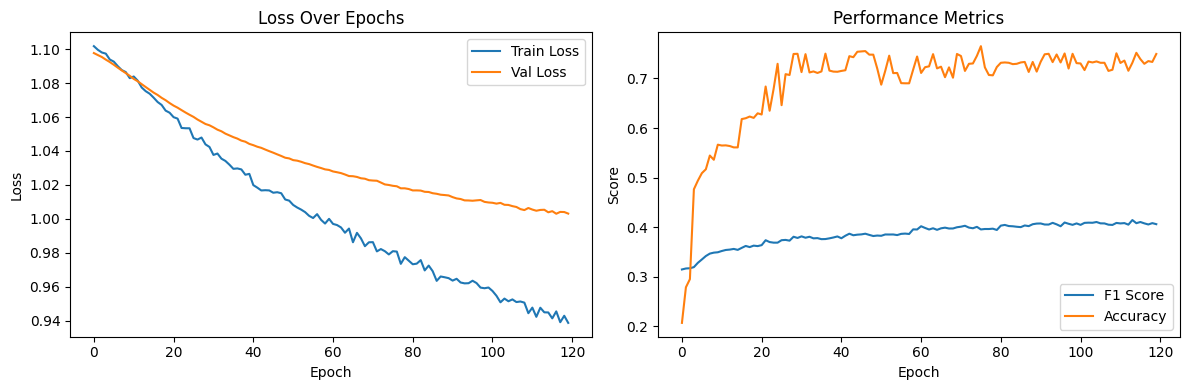

In [9]:
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot F1 and accuracy
plt.subplot(1, 2, 2)
plt.plot(history['f1_scores'], label='F1 Score')
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Performance Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction distribution visualization
def plot_prediction_distribution(outputs, threshold=0.5):
    plt.figure(figsize=(10, 6))
    
    # Plot sigmoid output distribution for each class
    sigmoid_outputs = torch.sigmoid(outputs).cpu().numpy()
    
    for i in range(sigmoid_outputs.shape[1]):
        sns.kdeplot(sigmoid_outputs[:, i], label=f'Class {i}')
    
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
    plt.title('Model Output Distribution')
    plt.xlabel('Sigmoid Output')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

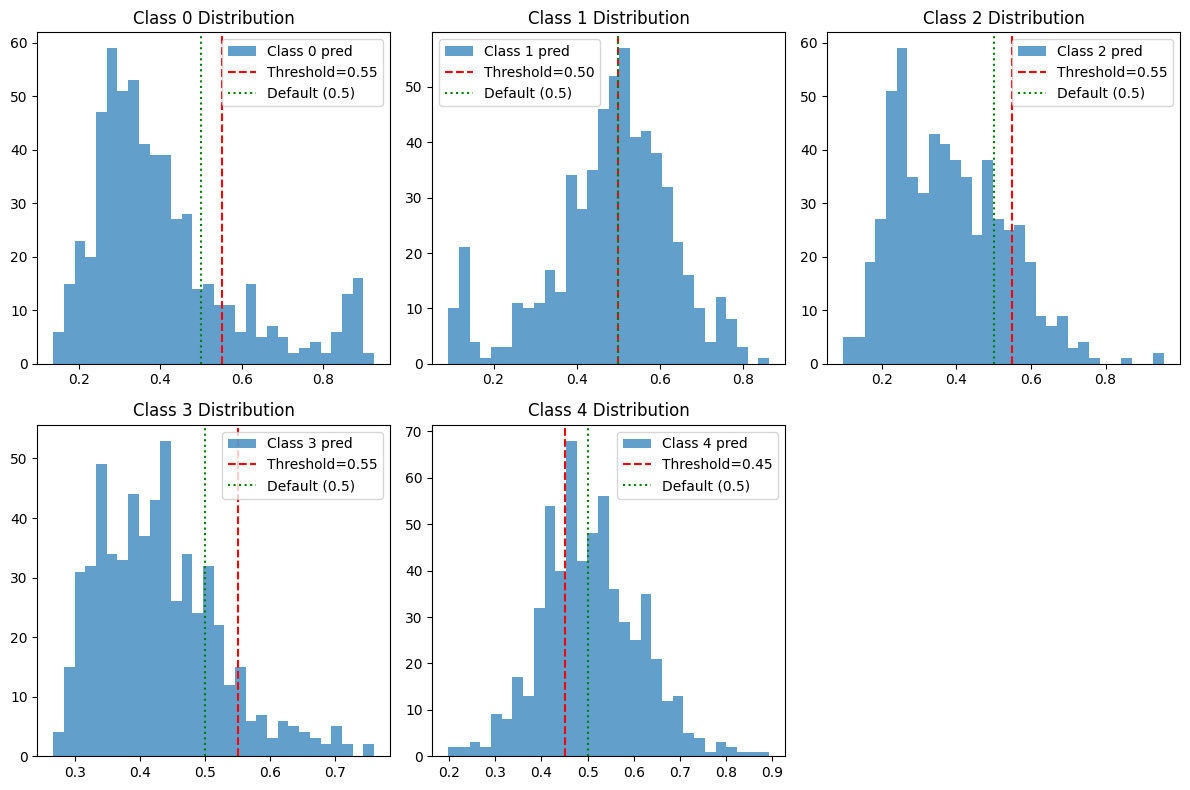

In [10]:
# Plot the distribution of predictions with thresholds
plt.figure(figsize=(12, 8))
for i in range(len(best_thresholds)):
    plt.subplot(2, 3, i+1)
    plt.hist(sigmoid_outputs[:, i], bins=30, alpha=0.7, label=f'Class {i} pred')
    plt.axvline(best_thresholds[i], color='r', linestyle='--', label=f'Threshold={best_thresholds[i]:.2f}')
    plt.axvline(0.5, color='g', linestyle=':', label='Default (0.5)')
    plt.title(f'Class {i} Distribution')
    plt.legend()
    
plt.tight_layout()
plt.show()

In [11]:
# Print class-specific metrics with optimal thresholds
print("\nClass-specific metrics with optimal thresholds:")
for i in range(len(best_thresholds)):
    class_accuracy = (all_preds[:, i] == all_labels[:, i]).mean()
    class_f1 = f1_score(all_labels[:, i], all_preds[:, i], average='binary')
    print(f"Class {i} - Accuracy: {class_accuracy:.4f}, F1 Score: {class_f1:.4f}, Threshold: {best_thresholds[i]:.2f}")


Class-specific metrics with optimal thresholds:
Class 0 - Accuracy: 0.8359, F1 Score: 0.4419, Threshold: 0.55
Class 1 - Accuracy: 0.6325, F1 Score: 0.5493, Threshold: 0.50
Class 2 - Accuracy: 0.8256, F1 Score: 0.2031, Threshold: 0.55
Class 3 - Accuracy: 0.8803, F1 Score: 0.2045, Threshold: 0.55
Class 4 - Accuracy: 0.5726, F1 Score: 0.6324, Threshold: 0.45


In [12]:
# Add this after all training is complete
print("\n===== FINAL RESULTS =====")
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Macro F1 Score: {f1:.4f}")

# Class breakdown
print("\nClass-by-class results:")
for i in range(train_dataset.num_labels):
    class_accuracy = (all_preds[:, i] == all_labels[:, i]).mean()
    class_f1 = f1_score(all_labels[:, i], all_preds[:, i], average='binary')
    print(f"Class {i} - Accuracy: {class_accuracy*100:.2f}%, F1 Score: {class_f1:.4f}")


===== FINAL RESULTS =====
Overall Accuracy: 74.94%
Macro F1 Score: 0.4062

Class-by-class results:
Class 0 - Accuracy: 83.59%, F1 Score: 0.4419
Class 1 - Accuracy: 63.25%, F1 Score: 0.5493
Class 2 - Accuracy: 82.56%, F1 Score: 0.2031
Class 3 - Accuracy: 88.03%, F1 Score: 0.2045
Class 4 - Accuracy: 57.26%, F1 Score: 0.6324
